In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for x, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(x[0])
    break


Shape of X [N, C, H, W]: torch.Size([50, 3, 32, 32])
Shape of y: torch.Size([50]) torch.int64
tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
         [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
         [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
         ...,
         [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
         [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
         [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

        [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
         [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
         [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
         ...,
         [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
         [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
         [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

        [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
         [0.2000, 0.1569, 0.1

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


This is the NN that was given to us in Lab 3. I will be loosely basing my following models off this:

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [30]:
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 32 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.fc_layers(x)
    
fcnn = FullyConnectedNN().to(device)
print(fcnn)


FullyConnectedNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)


In [34]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(65536, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        temp = self.conv_layers(x)
        return temp
    

cnn = CNN().to(device)
print(cnn)



CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=10, bias=True)
    (8): Softmax(dim=1)
  )
)


Need a loss function and an optimizer for FullyConnectedNN and CNN:

In [35]:
loss_fn = nn.CrossEntropyLoss()
fcnn_optimizer = torch.optim.SGD(fcnn.parameters(), lr=1e-3)
cnn_optimizer = torch.optim.SGD(cnn.parameters(), lr=1e-3)

I tweaked the train function from the lab because I found it easier to just make a for loop inside of the train function rather than calling it repeatedly. You can just pass in the number of epochs into the function.

In [36]:
def train(model, train_loader, loss_fn, optimizer, max_epochs=20):
    model.train()
    losses = []
    for epoch in range(max_epochs):
        epoch_loss = 0
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

        # Early stopping
        if epoch >= 3 and losses[-1] > losses[-2]:
            print("Early stopping due to loss increase.")
            break

    return losses

In [37]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).sum().item()
    accuracy = correct / size
    print(accuracy)

In [38]:
print("Training Fully Connected Neural Network")
fcnn_losses = train(fcnn, train_dataloader, loss_fn, fcnn_optimizer)

print("Training Convolutional Neural Network")
cnn_losses = train(cnn, train_dataloader, loss_fn, cnn_optimizer)

Training Fully Connected Neural Network
Epoch 1, Loss: 2.3021
Epoch 2, Loss: 2.3015
Epoch 3, Loss: 2.3010
Epoch 4, Loss: 2.3004
Epoch 5, Loss: 2.2998
Epoch 6, Loss: 2.2991
Epoch 7, Loss: 2.2984
Epoch 8, Loss: 2.2976
Epoch 9, Loss: 2.2967
Epoch 10, Loss: 2.2957
Epoch 11, Loss: 2.2945
Epoch 12, Loss: 2.2932
Epoch 13, Loss: 2.2917
Epoch 14, Loss: 2.2900
Epoch 15, Loss: 2.2882
Epoch 16, Loss: 2.2863
Epoch 17, Loss: 2.2843
Epoch 18, Loss: 2.2821
Epoch 19, Loss: 2.2798
Epoch 20, Loss: 2.2774
Training Convolutional Neural Network
Epoch 1, Loss: 2.3024
Epoch 2, Loss: 2.3020
Epoch 3, Loss: 2.3015
Epoch 4, Loss: 2.3007
Epoch 5, Loss: 2.2994
Epoch 6, Loss: 2.2969
Epoch 7, Loss: 2.2917
Epoch 8, Loss: 2.2824
Epoch 9, Loss: 2.2675
Epoch 10, Loss: 2.2458
Epoch 11, Loss: 2.2196
Epoch 12, Loss: 2.2017
Epoch 13, Loss: 2.1908
Epoch 14, Loss: 2.1820
Epoch 15, Loss: 2.1694
Epoch 16, Loss: 2.1519
Epoch 17, Loss: 2.1391
Epoch 18, Loss: 2.1302
Epoch 19, Loss: 2.1234
Epoch 20, Loss: 2.1180


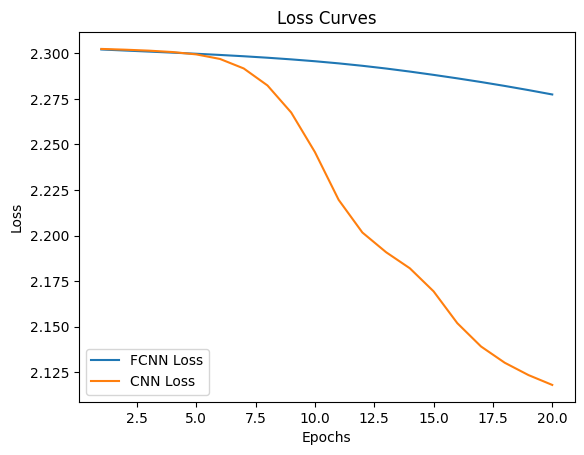

In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, len(fcnn_losses) + 1), fcnn_losses, label="FCNN Loss")
plt.plot(range(1, len(cnn_losses) + 1), cnn_losses, label="CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

In [40]:
print("Testing Fully Connected Neural Network Accuracy")
fcnn_accuracy = test(test_dataloader, fcnn, loss_fn)

print("Testing Convolutional Neural Network Accuracy")
cnn_accuracy = test(test_dataloader, cnn, loss_fn)

Testing Fully Connected Neural Network Accuracy
0.1384
Testing Convolutional Neural Network Accuracy
0.3429


Here is an example of the Fully Connected NN classifying an image with the wrong label:

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


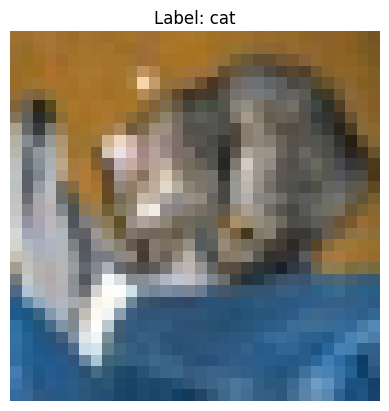

Predictions:  airplane
Actual:  cat


In [ ]:
from torch import permute
import numpy


classes = datasets.CIFAR10(root="data", download=False).classes

print(classes)

x, y = test_data[0][0], test_data[0][1]

x = x.permute(1, 2, 0).numpy()

plt.imshow(x)
plt.title(f"Correct Label: {classes[test_data[0][1]]}")
plt.axis("off")
plt.show()

x = torch.from_numpy(x)
x = x.unsqueeze(0)
x = x.to(device)
fcnn.eval()

with torch.no_grad():
    
    pred = fcnn(x)
    #TO DO: print out the predicted and actual class
    print("Predictions: ", classes[pred.argmax()])
    print("Actual: ", classes[y])

Here is an example of the CNN classifying an image with the wrong label:

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


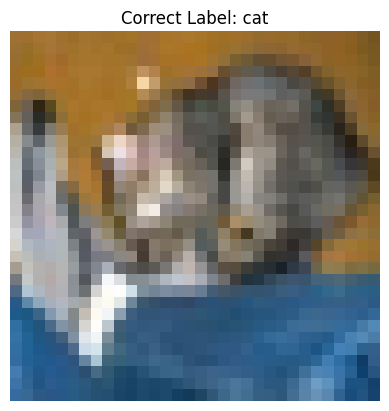

Predictions:  frog
Actual:  cat


In [51]:
from torch import permute
import numpy


classes = datasets.CIFAR10(root="data", download=False).classes

print(classes)

x, y = test_data[0][0], test_data[0][1]

x = x.permute(1, 2, 0).numpy()

plt.imshow(x)
plt.title(f"Correct Label: {classes[test_data[0][1]]}")
plt.axis("off")
plt.show()

x = torch.from_numpy(x)
x = x.unsqueeze(0)
x = x.permute(0, 3, 1, 2)
x = x.to(device)
cnn.eval()

with torch.no_grad():
    
    pred = cnn(x)
    #TO DO: print out the predicted and actual class
    print("Predictions: ", classes[pred.argmax()])
    print("Actual: ", classes[y])

1. Which of your models worked better? Why do you think it worked better?
The CNN definitely worked better than the FCNN. Although the accuracy is pretty bad for both... 
CNN typically works better for image analysis than FCNN because CNN uses its convolutional layers to better detect shapes. 

2. What advantages and shortcomings does accuracy have as an evaluation metric? Is there anything else you could do to more thoroughly evaluate your models?
One advantage of accuracy is that it is pretty easy to calculate. You just count the number of correct labels and calculate the accuracy. Also, accuracy can for the most part gauge a model's competency. One shortcoming of accuracy is that it can be biased/misleading depending on the dataset used. For example, if a dataset had much more of one class, class A, than others, than the accuracy may be high because it can label the class A images correctly but will not do so for other classes.